In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layer
import random
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, RNN, Masking, Dropout
from keras.preprocessing import sequence
random.seed(66)
np.random.seed(66)
tf.random.set_seed(66)

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#2. Get the file
downloaded = drive.CreateFile({'id':"1JgPepucROFeBublA_rA4niSjdVPSrSk7"})   # replace the id with id of file you want to access
downloaded.GetContentFile('age_gender.csv')

In [5]:
import pandas as pd
data = pd.read_csv('age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
data.shape

(23705, 5)

In [7]:
## normalizing pixels data
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name, autosize=False, width=500, height=500)
    fig.show()

In [86]:
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[0.5058824, 0.5019608, 0.5019608, 0.49411765, ..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[0.6431373, 0.2901961, 0.43529412, 0.65882355,..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[0.2627451, 0.27450982, 0.2784314, 0.27450982,..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[0.75686276, 0.77254903, 0.7764706, 0.78431374..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



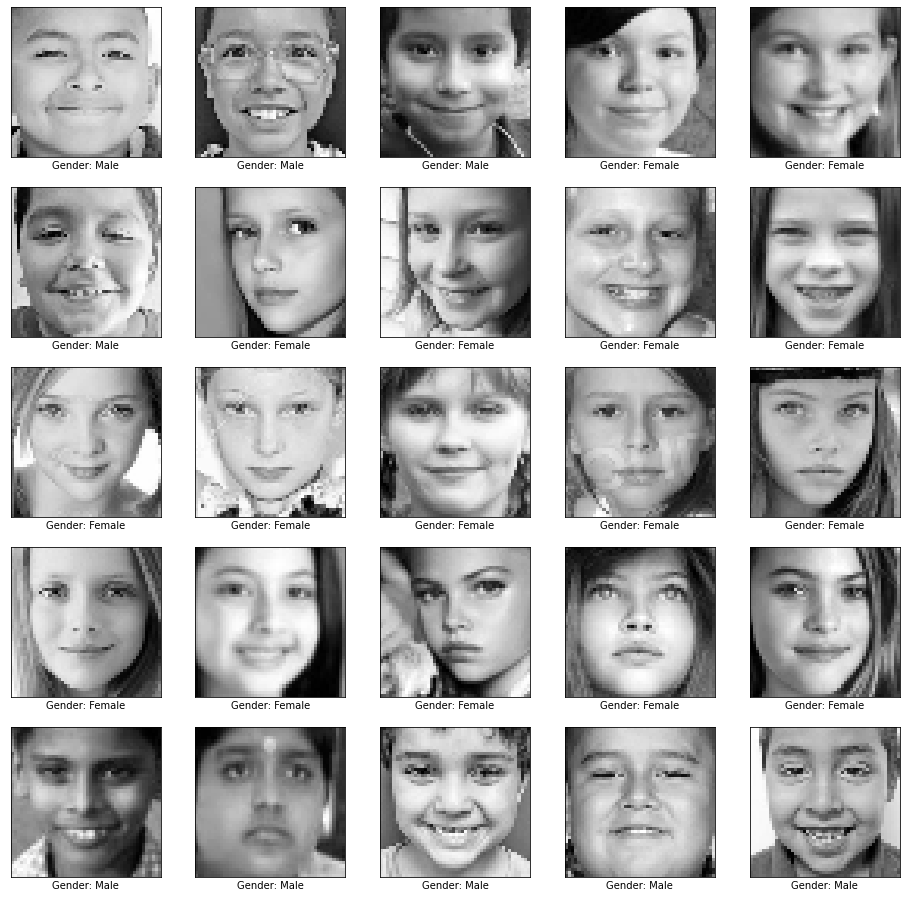

In [10]:
plt.figure(figsize=(16,16))
for i in range(1490,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48), cmap='gray')
    plt.xlabel(f"Gender: {'Female' if data['gender'].iloc[i]==1 else 'Male'}")
plt.show()

In [11]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [14]:
from sklearn.model_selection import train_test_split

X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=50)

In [15]:
model = tf.keras.Sequential([
    layer.InputLayer(input_shape=(48,48,1)),
    layer.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layer.BatchNormalization(),
    layer.MaxPooling2D((2, 2)),
    layer.Conv2D(64, (3, 3), activation='relu'),
    layer.MaxPooling2D((2, 2)),
    layer.Flatten(),
    layer.Dense(64, activation='relu'),
    layer.Dropout(rate=0.5),
    layer.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [16]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 2s 6ms/step - loss: 0.4637 - accuracy: 0.7829 - val_loss: 0.5345 - val_accuracy: 0.8172
Epoch 2/20
260/260 [==============================] - 1s 6ms/step - loss: 0.3275 - accuracy: 0.8585 - val_loss: 0.3586 - val_accuracy: 0.8437
Epoch 3/20
260/260 [==============================] - 1s 6ms/step - loss: 0.2954 - accuracy: 0.8715 - val_loss: 0.2776 - val_accuracy: 0.8799
Epoch 4/20
260/260 [==============================] - 1s 6ms/step - loss: 0.2718 - accuracy: 0.8831 - val_loss: 0.2724 - val_accuracy: 0.8761
Epoch 5/20
260/260 [==============================] - 1s 6ms/step - loss: 0.2507 - accuracy: 0.8926 - val_loss: 0.2723 - val_accuracy: 0.8816
Epoch 6/20
260/260 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.8944
Reached 0.2700 val_loss so cancelling training!
260/260 [==============================] - 1s 6ms/step - loss: 0.2404 - accuracy: 0.8944 - val_loss: 0.2601 - val_accuracy: 0.8891


Text(0.5, 1.0, 'Training History')

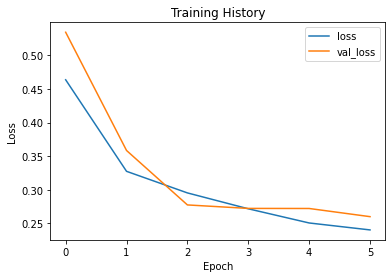

In [17]:
import matplotlib.pyplot as plt

los_df = pd.DataFrame(history.history)
los_df[['loss', 'val_loss']].plot();
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")


In [18]:
prediction = model.predict(X_test)


In [19]:
class_names = ['Male', 'Female']
test_images = np.reshape(X_test, (-1, 48, 48))
test_labels = y_test.reset_index(drop=True)
test_images.shape



(5216, 48, 48)

In [20]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img)
  
  predicted_label = np.int(np.round((predictions_array)))
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} ({})".format(class_names[predicted_label],                                
                                class_names[np.int(np.round((true_label)))]),
                                color=color)


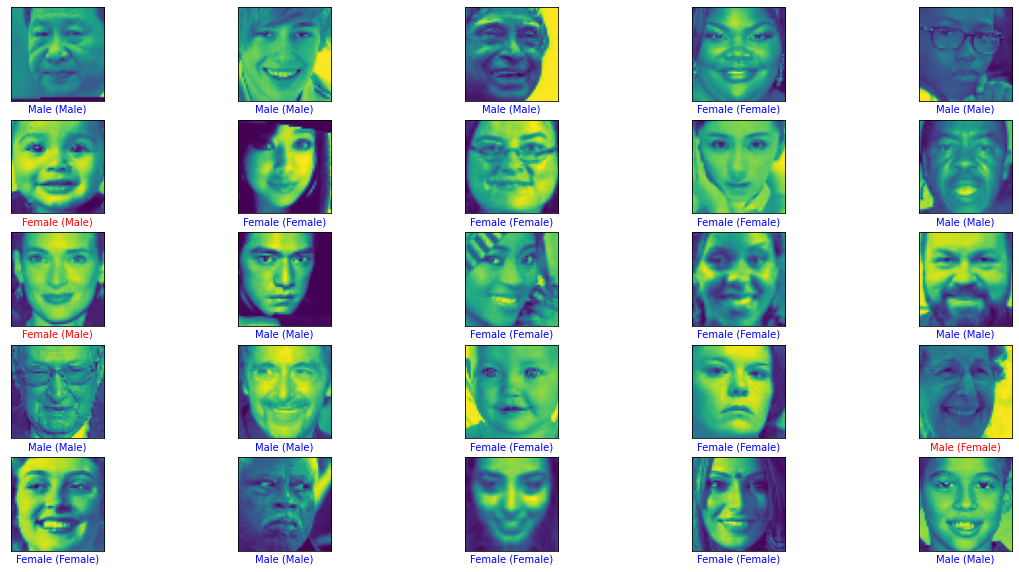

In [32]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, prediction, test_labels, test_images)
plt.show()

In [22]:
train_images = np.reshape(X_train, (-1, 48, 48))
train_labels = y_train.reset_index(drop=True)
train_images.shape

(18489, 48, 48)

In [79]:
#Build Models RNN
model2 = Sequential()
#model.add(Embedding(input_dim = len(x_train), output_dim = 100))

# Recurrent layer
model2.add(LSTM(32, input_shape = (train_images.shape[1:]), 
               return_sequences = False, activation = 'relu', dropout=0.1, recurrent_dropout=0.1 ))
#model.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, activation = 'relu'))

# Fully connected layer
model2.add(Dense(64, activation='relu'))

# Dropout for regularization
model2.add(Dropout(0.5))
layer.BatchNormalization()

model2.add(Dense(32, activation='relu'))

# Output layer
model2.add(Dense(1, activation='sigmoid'))
#model.add(LSTM(n_classes, activation='softmax'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                10368     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 14,593
Trainable params: 14,593
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Compile the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [81]:
history2 = model2.fit(train_images, train_labels, epochs = 20, batch_size = 56, validation_split=0.1, callbacks=[callback])

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Accuracy : {:2.0f}%'.format(test_acc*100))

Epoch 1/20
298/298 [==============================] - 49s 165ms/step - loss: 0.6490 - accuracy: 0.6255 - val_loss: 0.6083 - val_accuracy: 0.6690
Epoch 2/20
298/298 [==============================] - 46s 155ms/step - loss: 0.6217 - accuracy: 0.6629 - val_loss: 0.6017 - val_accuracy: 0.6793
Epoch 3/20
298/298 [==============================] - 46s 154ms/step - loss: 0.6090 - accuracy: 0.6725 - val_loss: 0.6002 - val_accuracy: 0.6744
Epoch 4/20
298/298 [==============================] - 46s 153ms/step - loss: 0.5939 - accuracy: 0.6871 - val_loss: 0.6187 - val_accuracy: 0.6458
Epoch 5/20
298/298 [==============================] - 45s 151ms/step - loss: 0.5872 - accuracy: 0.6879 - val_loss: 0.6066 - val_accuracy: 0.6696
Epoch 6/20
298/298 [==============================] - 46s 154ms/step - loss: 0.5638 - accuracy: 0.7094 - val_loss: 0.5508 - val_accuracy: 0.7290
Epoch 7/20
298/298 [==============================] - 45s 150ms/step - loss: 0.5433 - accuracy: 0.7237 - val_loss: 0.5314 - val_ac

Text(0.5, 1.0, 'Training History')

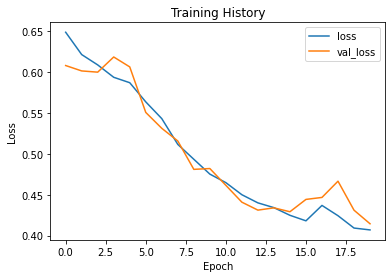

In [82]:
los_df = pd.DataFrame(history2.history)
los_df[['loss', 'val_loss']].plot();
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")


In [83]:
prediction2 = model2.predict(test_images)

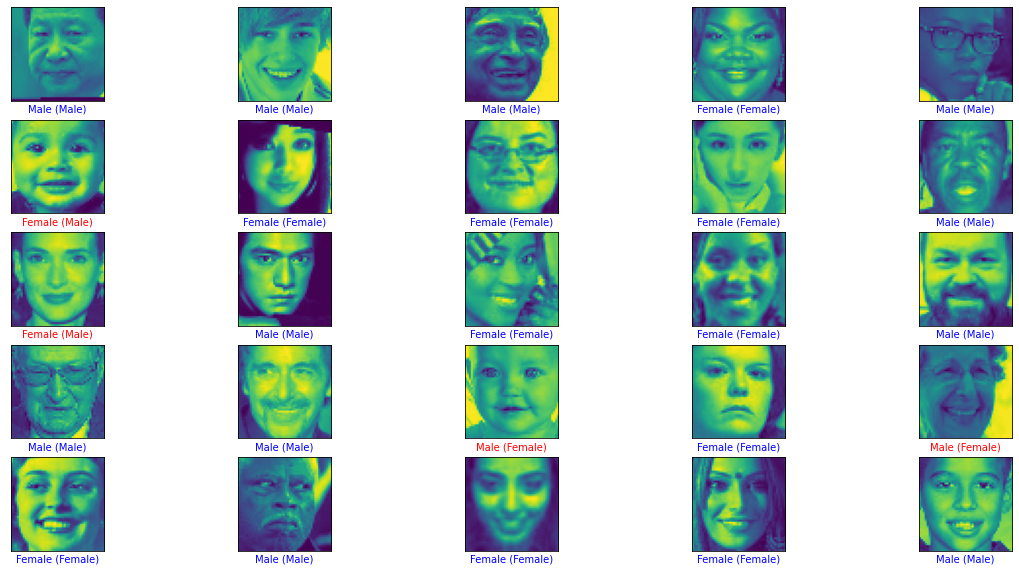

In [84]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, prediction2, test_labels, test_images)
plt.show()